In [1]:
%cd ../

/scratch/km817/iREC


In [2]:
import numpy as np
import pandas as pd
np.random.seed(0)
# np.random.seed(0)
# !wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data = pd.read_excel('ENB2012_data.xlsx', header=0).iloc[:, :10].values

In [3]:
import torch
import pyro
from torch import nn
import pyro.distributions as dist
from pyro.infer import HMC, MCMC, SVI, NUTS, TraceMeanField_ELBO
from pyro import poutine
from sklearn.datasets import load_boston
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import trange
from rec.utils import kl_estimate_with_mc
import matplotlib.pyplot as plt

In [4]:
x_ = data[:, :-2]
y_ = data[:, -2:]

In [5]:
test_splits_idxs = []
for d in range(x_.shape[-1]):
    sorted_x = np.argsort(x_[:,d], axis=-1)
    total_points = sorted_x.shape[0]
    lower_third = total_points // 3
    upper_third = total_points * 2 // 3
    test_index = sorted_x[lower_third: upper_third]
    test_splits_idxs.append(test_index)

In [6]:
test_splits_x, test_splits_y = [], []
train_splits_x, train_splits_y = [], []
for d in range(x_.shape[-1]):
    a = np.arange(x_.shape[0])
    test_index = test_splits_idxs[d]
    train_index = np.delete(a, test_index, axis=0)
    x_train = x_[train_index]
    y_train = y_[train_index]
    x_test = x_[test_index][:]
    y_test = y_[test_index][:]
    x_m = x_train.mean(0)
    x_s = x_train.std(0)
    x_train = (x_train - x_m) / x_s
    x_test = (x_test - x_m) / x_s
    test_splits_x.append(x_test)
    test_splits_y.append(y_test)
    train_splits_x.append(x_train)
    train_splits_y.append(y_train)

In [7]:
D_in = x_train.shape[-1]
D_out = y_test.shape[-1]
x_train = torch.FloatTensor(np.array(train_splits_x))
y_train = torch.FloatTensor(np.array(train_splits_y))
x_test= torch.FloatTensor(np.array(test_splits_x))
y_test = torch.FloatTensor(np.array(test_splits_y))

In [8]:
def regression_model(x, y=None, weight_samples=None, in_size=1, num_nodes=10, out_size=1, ELBO_BETA=1.):
    # sample vector of weights for regression
    total_weights = (in_size + 1) * num_nodes + (num_nodes + 1) * num_nodes + (num_nodes + 1) * out_size
    # sample params
    with poutine.scale(scale=ELBO_BETA):
        params = pyro.sample("params", dist.Normal(torch.zeros(total_weights + D_out), 1.).to_event(1))
    weights, rho = params[:-D_out], params[-D_out:]

    idx = 0
    fc1_weights = weights[idx: idx + in_size * num_nodes].reshape(num_nodes, in_size)
    idx += in_size * num_nodes
    fc1_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc2_weights = weights[idx: idx + num_nodes * num_nodes].reshape(num_nodes, num_nodes)
    idx += num_nodes * num_nodes
    fc2_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc3_weights = weights[idx: idx + num_nodes * out_size].reshape(out_size, num_nodes)
    idx += num_nodes * out_size
    fc3_bias = weights[idx: idx + out_size].reshape(out_size)
    idx += out_size

    assert idx == total_weights, "Something wrong with number of weights!"

    # compute forward pass
    batch_shape = x.shape[0]
    x = torch.einsum("ij, kj -> ki", fc1_weights, x) + fc1_bias[None].repeat(batch_shape, 1)
    x = torch.relu(x)

    x = torch.einsum("ij, kj -> ki", fc2_weights, x) + fc2_bias[None].repeat(batch_shape, 1)
    x = torch.relu(x)

    x = torch.einsum("ij, kj -> ki", fc3_weights, x) + fc3_bias[None].repeat(batch_shape, 1)
    mu = x.squeeze()

    with pyro.plate("data"):
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=mu, 
                                                         covariance_matrix=torch.diag(F.softplus(rho) ** 2)), obs=y)
    return mu


def KDE_guide(x, y=None, weight_samples=None, in_size=D_in, num_nodes=10, out_size=1, ELBO_BETA=None):
    total_weights = (in_size + 1) * num_nodes + (num_nodes + 1) * num_nodes + (num_nodes + 1) * out_size
    iso_noise = pyro.param("iso_noise", torch.tensor(1e-5), constraint=dist.constraints.positive)
    assignment = dist.Categorical(probs=torch.ones(weight_samples.shape[0])).sample()

    # sample assigmnent
    with poutine.scale(scale=ELBO_BETA):
        params = pyro.sample("params", dist.Normal(weight_samples[assignment], iso_noise).to_event(1))

    weights, rho = params[:-1], params[-1]
    idx = 0
    fc1_weights = weights[idx: idx + in_size * num_nodes].reshape(num_nodes, in_size)
    idx += in_size * num_nodes
    fc1_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc2_weights = weights[idx: idx + num_nodes * num_nodes].reshape(num_nodes, num_nodes)
    idx += num_nodes * num_nodes
    fc2_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc3_weights = weights[idx: idx + num_nodes * out_size].reshape(out_size, num_nodes)
    idx += num_nodes * out_size
    fc3_bias = weights[idx: idx + out_size].reshape(out_size)
    idx += out_size

    assert idx == total_weights, "Something wrong with number of weights!"

    # compute forward pass
    batch_shape = x.shape[0]
    x = torch.einsum("ij, kj -> ki", fc1_weights, x) + fc1_bias[None].repeat(batch_shape, 1)
    x = torch.relu(x)

    x = torch.einsum("ij, kj -> ki", fc2_weights, x) + fc2_bias[None].repeat(batch_shape, 1)
    x = torch.relu(x)

    x = torch.einsum("ij, kj -> ki", fc3_weights, x) + fc3_bias[None].repeat(batch_shape, 1)
    mu = x.squeeze()

def make_empirical_gmm(samples, num_nodes, x_test):
    rho_noise = samples['params'][:, -D_out:]
    noise = F.softplus(rho_noise) ** 2
    preds_dict = Predictive(regression_model, samples, return_sites=['_RETURN'])(x_test, None, num_nodes=num_nodes,
                                                                                 in_size=D_in, out_size=D_out)
    preds = preds_dict['_RETURN']
    mix = dist.Categorical(torch.ones(preds.shape[0]))
    comp = dist.MultivariateNormal(loc=preds.squeeze().permute(1, 0, 2), covariance_matrix=torch.diag_embed(noise))
    gmm = dist.MixtureSameFamily(mix, comp)
    return gmm

In [9]:
class deterministic_regression_model(nn.Module):
    def __init__(self, params, in_size=1, num_nodes=10, out_size=1):
        super(deterministic_regression_model, self).__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.activation = torch.relu
        self.num_nodes = num_nodes
        weights, rho = params[:-out_size], params[-out_size:]

        idx = 0
        self.fc1_weights = weights[idx: idx + self.in_size * self.num_nodes].reshape(self.num_nodes, self.in_size)
        idx += self.in_size * self.num_nodes
        self.fc1_bias = weights[idx: idx + self.num_nodes].reshape(self.num_nodes)
        idx += self.num_nodes

        self.fc2_weights = weights[idx: idx + self.num_nodes * self.num_nodes].reshape(self.num_nodes, self.num_nodes)
        idx += self.num_nodes * self.num_nodes
        self.fc2_bias = weights[idx: idx + self.num_nodes].reshape(self.num_nodes)
        idx += self.num_nodes

        self.fc3_weights = weights[idx: idx + self.num_nodes *self.out_size].reshape(self.out_size, self.num_nodes)
        idx += self.num_nodes *self.out_size
        self.fc3_bias = weights[idx: idx +self.out_size].reshape(self.out_size)
        idx +=self.out_size
        
        self.weights = weights
        self.rho = rho
        self.params = params

        # compute forward pass
    
    def forward(self, x):
        batch_shape = x.shape[0]
        x = torch.einsum("ij, kj -> ki", self.fc1_weights, x) + self.fc1_bias[None].repeat(batch_shape, 1)
        x = torch.relu(x)

        x = torch.einsum("ij, kj -> ki", self.fc2_weights, x) + self.fc2_bias[None].repeat(batch_shape, 1)
        x = torch.relu(x)

        x = torch.einsum("ij, kj -> ki", self.fc3_weights, x) + self.fc3_bias[None].repeat(batch_shape, 1)
        x = x.squeeze()
        
        return x
    
    def weight_prior_lp(self):
        return dist.Normal(loc=0., scale=1.).log_prob(self.params).mean()
    
    def data_likelihood(self, x, y):
        likelihood = dist.Normal(loc=self.forward(x),
                              scale=F.softplus(self.rho))
        return likelihood.log_prob(y).sum(-1).mean()
    
    def joint_log_prob(self, x, y):
        return self.data_likelihood(x, y) + self.weight_prior_lp(x, y)
    
    def make_weights_from_sample(self, params):
        weights, rho = params[:-self.out_size], params[-self.out_size:]

        idx = 0
        self.fc1_weights = weights[idx: idx + self.in_size * self.num_nodes].reshape(self.num_nodes, self.in_size)
        idx += self.in_size * self.num_nodes
        self.fc1_bias = weights[idx: idx + self.num_nodes].reshape(self.num_nodes)
        idx += self.num_nodes

        self.fc2_weights = weights[idx: idx + self.num_nodes * self.num_nodes].reshape(self.num_nodes, self.num_nodes)
        idx += self.num_nodes * self.num_nodes
        self.fc2_bias = weights[idx: idx + self.num_nodes].reshape(self.num_nodes)
        idx += self.num_nodes

        self.fc3_weights = weights[idx: idx + self.num_nodes * self.out_size].reshape(self.out_size, self.num_nodes)
        idx += self.num_nodes *self.out_size
        self.fc3_bias = weights[idx: idx + self.out_size].reshape(self.out_size)
        idx += self.out_size
        
        self.weights = weights
        self.rho = rho
        self.params = params

In [10]:
pyro.set_rng_seed(10)
ELBO_BETA = 1.
S=5
in_size = x_train.shape[-1]
num_nodes = 3

# run HMC
kernel = HMC(regression_model, step_size=0.001, num_steps=5, target_accept_prob=0.8)
nuts_kernel = NUTS(regression_model, step_size=0.1, target_accept_prob=0.5, max_tree_depth=5)
mcmc = MCMC(kernel, num_samples=1000, warmup_steps=1000, num_chains=1)
mcmc.run(x_train[S], y_train[S], ELBO_BETA=ELBO_BETA, num_nodes=num_nodes, in_size=D_in, out_size=D_out)

Sample: 100%|██████████| 2000/2000 [00:28, 71.19it/s, step size=3.02e-01, acc. prob=0.881] 


In [11]:
full_samples = mcmc.get_samples(50)
from pyro.infer import Predictive
pred = Predictive(regression_model, full_samples, return_sites=['obs', '_RETURN'])(x_test[S], None, num_nodes=num_nodes, in_size=D_in, out_size=D_out)
HMC_RMSE = ((pred['_RETURN'].mean(0) - y_test[S]) ** 2).mean().sqrt()

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/pyro/distributions/torch_patch.py:81: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  return torch.stack([v.symeig(eigenvectors=False)[0][:1] > 0.0


In [12]:
optimizer = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {'lr': 1}, 'gamma': .95})
# train KDE
svi = SVI(regression_model, KDE_guide, scheduler, loss=TraceMeanField_ELBO())

num_iterations = 1000
pyro.clear_param_store()
pbar = trange(num_iterations)
losses = []
for j in pbar:
    # calculate the loss and take a gradient step
    loss = svi.step(x_train[S], y_train[S], full_samples['params'], 
                    ELBO_BETA=ELBO_BETA, num_nodes=num_nodes, in_size=D_in, out_size=D_out)
    losses.append(loss)
    pbar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))
    scheduler.step()
kde_noise = pyro.param("iso_noise")
flattened_params = full_samples['params']
kde_mix = dist.Categorical(probs=torch.ones(flattened_params.shape[0]))
kde_comps = dist.MultivariateNormal(loc=flattened_params,
                                    covariance_matrix=kde_noise * torch.eye(flattened_params.shape[-1]))
kde = dist.MixtureSameFamily(kde_mix, kde_comps)
prior = dist.MultivariateNormal(loc=torch.ones_like(flattened_params[0]),
                                covariance_matrix=torch.eye(flattened_params[0].shape[-1]))
kl_kde_prior = kl_estimate_with_mc(kde, prior)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
kde_noise

tensor(0.0282, grad_fn=<AddBackward0>)

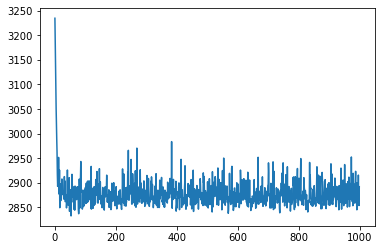

In [14]:
plt.plot(losses)

In [15]:
kde_sample = kde.sample((50,))
kde_samples = {"params" : kde_sample}
kde_pred = Predictive(regression_model, kde_samples, return_sites=['obs', '_RETURN'])(x_test[S], None, 
                                                                        num_nodes=num_nodes, in_size=D_in,
                                                                                     out_size=D_out)
KDE_RMSE = ((kde_pred['_RETURN'].mean(0) - y_test[S]) ** 2).mean().sqrt()

In [ ]:
optimizer = pyro.optim.Adam({"lr": 1e-3})
# train Factored Gaussian approx
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(regression_model)
svi = SVI(regression_model, guide, optimizer, loss=TraceMeanField_ELBO())
num_iterations = 50000
pyro.clear_param_store()
pbar = trange(num_iterations)
losses = []
for j in pbar:
    # calculate the loss and take a gradient step
    loss = svi.step(x_train[S], y_train[S], ELBO_BETA=ELBO_BETA, num_nodes=num_nodes, in_size=D_in, out_size=D_out)
    losses.append(loss)
    pbar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))
guide.requires_grad_(False)

params = []
for name, value in pyro.get_param_store().items():
    params.append(pyro.param(name))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
plt.plot(losses[-1000:])

In [ ]:
means, stds = params
variational_posterior = dist.MultivariateNormal(loc=means, covariance_matrix=torch.diag(stds ** 2))
variational_sample = variational_posterior.sample((50,))
variational_samples = {"params" : variational_sample}
kl_var_prior = kl_estimate_with_mc(variational_posterior, prior)
var_pred = Predictive(regression_model, variational_samples, return_sites=['obs', '_RETURN'])(x_test[S], None, 
                                                                        num_nodes=num_nodes, in_size=D_in,
                                                                                             out_size=D_out)
VAR_RMSE = ((var_pred['_RETURN'].mean(0) - y_test[S]) ** 2).mean().sqrt()

In [ ]:
hmc_gmm = make_empirical_gmm(full_samples, num_nodes, x_test[S])
kde_gmm = make_empirical_gmm(kde_samples, num_nodes, x_test[S])
var_gmm = make_empirical_gmm(variational_samples, num_nodes, x_test[S])
print(f"The final KLs are: KDE {kl_kde_prior}, VAR {kl_var_prior}\n"
      f"The final RMSE are: HMC {HMC_RMSE}, KDE {KDE_RMSE}, VAR {VAR_RMSE}\n"
      f"The final LLs are: HMC {hmc_gmm.log_prob(y_test[S]).mean()}, KDE {kde_gmm.log_prob(y_test[S]).mean()}, VAR {var_gmm.log_prob(y_test[S]).mean()}.")

In [ ]:
hmc_gmm = make_empirical_gmm(full_samples, num_nodes, x_train[S])
kde_gmm = make_empirical_gmm(kde_samples, num_nodes, x_train[S])
var_gmm = make_empirical_gmm(variational_samples, num_nodes, x_train[S])
print(f"The final KLs are: KDE {kl_kde_prior}, VAR {kl_var_prior}\n"
      f"The final RMSE are: HMC {HMC_RMSE}, KDE {KDE_RMSE}, VAR {VAR_RMSE}\n"
      f"The final LLs are: HMC {hmc_gmm.log_prob(y_train[S]).mean()}, KDE {kde_gmm.log_prob(y_train[S]).mean()}, VAR {var_gmm.log_prob(y_train[S]).mean()}.")

# Compress weights

In [ ]:
#lets compress some samples
#### sample weights with compression algorithm
from tqdm.notebook import trange
from rec.beamsearch.Coders.Encoder_Empirical import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling_BNNs import GreedySampler
import pyro.distributions as dist

In [ ]:
dummy_model = deterministic_regression_model(full_samples['params'][10], in_size=D_in, num_nodes=num_nodes, out_size=D_out)


In [ ]:
samples = full_samples['params']

In [ ]:
kl_q_p = kl_kde_prior

In [ ]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
dummy_encoder = Encoder(dummy_model,
                     x_train[S],
                     y_train[S],
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1.,
                     total_kl=kl_q_p)

z_sample = samples.mean(0)
omega = 5
n_trajectories = 64
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1.
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, kl_q_p, n_trajectories, prior_var)
aux_vars = emp_opt.run_optimiser(epochs=5000)

In [ ]:
del dummy_encoder

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 500
compressed_weights_emp_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(dummy_model,
                     x_train[S],
                     y_train[S],
                     samples,
                     initial_seed,
                     coding_sampler,
                     selection_sampler,
                     auxiliary_posterior,
                     omega,
                     beamwidth,
                     epsilon=epsilon,
                     prior_var=1.,
                     total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_emp_low_eps.append(w[0])

In [ ]:
weight_samples = torch.zeros([0])
for w in compressed_weights_emp_low_eps:
    weight_samples = torch.cat([weight_samples, w[None]], dim=0)

In [ ]:
weight_samples = {'params':weight_samples}

In [ ]:
compressed = Predictive(regression_model, weight_samples, return_sites=['obs', '_RETURN'])(x_test[S], None, 
                                                                        num_nodes=num_nodes, in_size=D_in,
                                                                                             out_size=D_out)

In [ ]:
compressed_gmm = make_empirical_gmm(weight_samples, num_nodes, x_test[S])

In [ ]:
compressed_gmm.log_prob(y_test[S]).mean()

In [ ]:
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.KDEPosterior import KDEPosterior
from rec.beamsearch.samplers.GreedySampling_BNNs import GreedySampler
from rec.beamsearch.Coders.Encoder_KDE_BNN import EncoderKDE

In [ ]:
KDE_target = kde

In [ ]:
coding_sampler = CodingSampler
auxiliary_posterior = KDEPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.2
num_compressed_samples = 500
compressed_weights_kde_low_eps = []

for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = EncoderKDE(model=dummy_model,
                         x_data=x_train[S],
                         y_data=y_train[S],
                         target=KDE_target,
                         initial_seed=initial_seed,
                         coding_sampler=coding_sampler,
                         selection_sampler=selection_sampler,
                         auxiliary_posterior=auxiliary_posterior,
                         omega=omega,
                         epsilon=epsilon,
                         beamwidth=beamwidth,
                         prior_var=1.,
                        total_kl=kl_q_p)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    w, idx = encoder.run_encoder()
    compressed_weights_kde_low_eps.append(w[0])

In [ ]:
weight_samples_kde = torch.zeros([0])
for w in compressed_weights_kde_low_eps:
    weight_samples_kde = torch.cat([weight_samples_kde, w[None]], dim=0)

In [ ]:
weight_samples_kde = {'params':weight_samples_kde}

In [ ]:
compressed = Predictive(regression_model, weight_samples_kde, return_sites=['obs', '_RETURN'])(x_test[S], None, 
                                                                        num_nodes=num_nodes, in_size=D_in,
                                                                                             out_size=D_out)

In [ ]:
compressed_gmm_kde = make_empirical_gmm(weight_samples_kde, num_nodes, x_test[S])

In [ ]:
compressed_gmm_kde.log_prob(y_test[S]).mean()

In [ ]:
compressed_gmm_kde_train = make_empirical_gmm(weight_samples_kde, num_nodes, x_train[S])

compressed_gmm_kde_train.log_prob(y_train[S]).mean()

# Variational Scheme

In [ ]:
#### sample weights with compression algorithm
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser
from tqdm.notebook import trange
coding_sampler = CodingSampler
auxiliary_posterior = VariationalPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.



compute_params_enc =  encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1.)

n_auxiliaries = compute_params_enc.n_auxiliary
kl_q_p = compute_params_enc.total_kl
var_opt = VariationalOptimiser(compute_params_enc.target, omega, n_auxiliaries, kl_q_p, n_trajectories=16, total_var=1.)
aux_vars = var_opt.run_optimiser(epochs=1000, lr=1e-1)

In [ ]:
initial_seed = 0
beamwidth = 1
epsilon = 0.2

compressed_weights_var_high_eps = []
num_compressed_samples = 500
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1.)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_var_high_eps.append(w[0])

In [ ]:
weight_samples_var = torch.zeros([0])
for w in compressed_weights_var_high_eps:
    weight_samples_var = torch.cat([weight_samples_var, w[None]], dim=0)

In [ ]:
weight_samples_var = {'params':weight_samples_var}

In [ ]:
compressed = Predictive(regression_model, weight_samples_var, return_sites=['obs', '_RETURN'])(x_test[S], None, 
                                                                        num_nodes=num_nodes, in_size=D_in,
                                                                                             out_size=D_out)

In [ ]:
compressed_gmm_var = make_empirical_gmm(weight_samples_var, num_nodes, x_test[S])

compressed_gmm_var.log_prob(y_test[S]).mean()

In [ ]:
compressed_gmm_var_train = make_empirical_gmm(weight_samples_var, num_nodes, x_train[S])

compressed_gmm_var_train.log_prob(y_train[S]).mean()

In [ ]:
import pickle as pkl
pkl.dump(full_samples, open(f"PickledStuff/BNN_UCI/ENERGY/full_samples_split{S}.pkl", "wb"))
pkl.dump(kde_samples, open(f"PickledStuff/BNN_UCI/ENERGY/kde_samples_split{S}.pkl", "wb"))
pkl.dump(variational_samples, open(f"PickledStuff/BNN_UCI/ENERGY/variational_samples_split{S}.pkl", "wb"))
pkl.dump(weight_samples_kde, open(f"PickledStuff/BNN_UCI/ENERGY/compressed_kde_samples_split{S}.pkl", "wb"))
pkl.dump(weight_samples, open(f"PickledStuff/BNN_UCI/ENERGY/compressed_emp_samples_split{S}.pkl", "wb"))
pkl.dump(weight_samples_var, open(f"PickledStuff/BNN_UCI/ENERGY/compressed_var_samples_split{S}.pkl", "wb"))
pkl.dump(kl_kde_prior, open(f"PickledStuff/BNN_UCI/ENERGY/kde_kl_split{S}.pkl", "wb"))
pkl.dump(kl_var_prior, open(f"PickledStuff/BNN_UCI/ENERGY/var_kl_split{S}.pkl", "wb"))